In [0]:
import pandas as pd

In [2]:
! pip install category_encoders

In [3]:
train_df = pd.read_csv("train_data.csv")
train_df.shape

(1799805, 6)

In [4]:
train_df.head()

,date_hour,area_name,date_accident,hour_time,no_of_accidents,is_accident
0,2010-01-01 00:00:00,Olympic,2010-01-01 00:00:00,0,0.0,0
1,2010-01-01 01:00:00,Olympic,2010-01-01 00:00:00,100,1.0,1
2,2010-01-01 02:00:00,Olympic,2010-01-01 00:00:00,200,0.0,0
3,2010-01-01 03:00:00,Olympic,2010-01-01 00:00:00,300,1.0,1
4,2010-01-01 04:00:00,Olympic,2010-01-01 00:00:00,400,0.0,0


In [5]:
#Baseline Prediction for majority classsifer
train_df['is_accident'].value_counts(normalize=True)

0    0.771062
1    0.228938
Name: is_accident, dtype: float64

# Will an accident happen in a area of Los Angeles in the next one hour


### Base Line Accuracy

##### With 77% accuracy we can predict that an accident will not happen in a area within the next one hour

##### As baseline accuracy is high, we will be using AUC ROC metric for Model performance of this classification problem

In [0]:
#Converting columns to datetime
train_df['date_hour']=pd.to_datetime(train_df['date_hour'])

In [0]:
area_names = train_df.area_name.unique()

In [8]:
area_names

array(['Olympic', 'Southeast', 'Foothill', 'Hollywood', 'Mission',
       'Northeast', 'Newton', 'Central', 'N Hollywood', 'Southwest',
       'Harbor', 'Devonshire', 'Pacific', 'Rampart', 'Wilshire',
       '77th Street', 'West LA', 'Topanga', 'Van Nuys', 'West Valley',
       'Hollenbeck'], dtype=object)

In [9]:
#Frequency of accidents in Los Angeles in any given hour
train_df['no_of_accidents'].value_counts(normalize=True)

0.0     7.710619e-01
1.0     1.896428e-01
2.0     3.343084e-02
3.0     5.037212e-03
4.0     7.050764e-04
5.0     9.667714e-05
6.0     1.777970e-05
7.0     4.444926e-06
8.0     1.666847e-06
14.0    5.556157e-07
12.0    5.556157e-07
11.0    5.556157e-07
Name: no_of_accidents, dtype: float64

In [0]:
#Creating features based on no of accidents happened in the past hours in that area
empty_df = []
laghours = [4,12,24,168,720,2880,8760]
for area in area_names:
    train_area = train_df[train_df.area_name==area].copy()
    train_area['no_past1hour']=train_df['no_of_accidents'].shift(1)
    for lhour in laghours:
        name = 'past_'+str(lhour)+'hours'
        train_area[name]=train_area['no_past1hour'].rolling(lhour).sum()
    empty_df.append(train_area)

In [11]:
#Final data after creating features
train = pd.concat(empty_df)
train.shape

(1799805, 14)

In [0]:
#Filling all Nan values with -1
train = train.fillna(-1)

In [0]:
#Adding more features to the data
train['day']=train['date_hour'].dt.day
train['month']=train['date_hour'].dt.month
train['dayofweek']=train['date_hour'].dt.dayofweek
train['year']=train['date_hour'].dt.year

In [14]:
#Removing No of accidents as that is a leakage feature and date_hour as it is equal to a index
train = train.drop(columns=['no_of_accidents'])
train.shape

(1799805, 17)

In [15]:
train.tail()

,date_hour,area_name,date_accident,hour_time,is_accident,no_past1hour,past_4hours,past_12hours,past_24hours,past_168hours,past_720hours,past_2880hours,past_8760hours,day,month,dayofweek,year
1799800,2019-10-11 20:00:00,Hollenbeck,2019-10-11 00:00:00,2000,0,0.0,0.0,0.0,2.0,28.0,155.0,641.0,2020.0,11,10,4,2019
1799801,2019-10-11 21:00:00,Hollenbeck,2019-10-11 00:00:00,2100,0,0.0,0.0,0.0,2.0,28.0,155.0,640.0,2020.0,11,10,4,2019
1799802,2019-10-11 22:00:00,Hollenbeck,2019-10-11 00:00:00,2200,0,0.0,0.0,0.0,2.0,28.0,155.0,640.0,2020.0,11,10,4,2019
1799803,2019-10-11 23:00:00,Hollenbeck,2019-10-11 00:00:00,2300,0,0.0,0.0,0.0,2.0,28.0,154.0,640.0,2020.0,11,10,4,2019
1799804,2019-10-12 00:00:00,Hollenbeck,2019-10-12 00:00:00,0,0,0.0,0.0,0.0,2.0,28.0,154.0,640.0,2020.0,12,10,5,2019


In [0]:
#Creating a train,valid and test dataset based on time slicing
#Train set will be data before 2018
#Valid set will be data for year 2018
#Test set will be data for year 2019

In [0]:
target = 'is_accident'

In [18]:
train_set = train[train.date_hour<'2018-01-01']
valid_set = train[(train.date_hour>='2018-01-01')&(train.date_hour<'2019-01-01')]
test_set = train[train.date_hour>='2019-01-01']
print("Train :",train_set.shape[0])
print("Valid :",valid_set.shape[0])
print("Valid :",test_set.shape[0])

Train : 1472688
Valid : 183960
Valid : 143157


In [0]:
#separating target and training data
y_train = train_set[target]
train_set = train_set.drop(columns=target)
y_valid = valid_set[target]
valid_set = valid_set.drop(columns=target)
y_test = test_set[target]
test_set = test_set.drop(columns=target)

In [0]:
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    #LGBMClassifier(max_depth=8,learning_rate=0.03,n_estimators=1500,min_child_samples=20)
)

In [0]:
features = train_set.columns.drop(['date_hour','date_accident'])

In [59]:
features

Index(['area_name', 'hour_time', 'no_past1hour', 'past_4hours', 'past_12hours',
       'past_24hours', 'past_168hours', 'past_720hours', 'past_2880hours',
       'past_8760hours', 'day', 'month', 'dayofweek', 'year'],
      dtype='object')

In [0]:
 X_train = pipeline.fit_transform(train_set[features])
 X_valid = pipeline.transform(valid_set[features])
 X_test = pipeline.transform(test_set[features])




In [68]:
X_train.head()

,area_name,hour_time,no_past1hour,past_4hours,past_12hours,past_24hours,past_168hours,past_720hours,past_2880hours,past_8760hours,day,month,dayofweek,year
0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4,2010
1,1,100,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4,2010
2,1,200,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4,2010
3,1,300,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4,2010
4,1,400,1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1,4,2010


In [0]:

eval_set = [(X_train,y_train),(X_valid,y_valid)]
model = LGBMClassifier(learning_rate=0.01,subsample= 1.0,
                      n_estimators = 500,min_child_weight = 3,
                       gamma =  1, colsample_bytree = 0.8)

In [90]:
model.fit(X_train,y_train,eval_set=eval_set,eval_metric='auc',
                      early_stopping_rounds=50)

[1]	training's binary_logloss: 0.53167	training's auc: 0.579408	valid_1's binary_logloss: 0.568894	valid_1's auc: 0.57503
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_logloss: 0.531115	training's auc: 0.658897	valid_1's binary_logloss: 0.568171	valid_1's auc: 0.65749
[3]	training's binary_logloss: 0.530572	training's auc: 0.663489	valid_1's binary_logloss: 0.567455	valid_1's auc: 0.661715
[4]	training's binary_logloss: 0.53004	training's auc: 0.664589	valid_1's binary_logloss: 0.566783	valid_1's auc: 0.662001
[5]	training's binary_logloss: 0.529516	training's auc: 0.664689	valid_1's binary_logloss: 0.566105	valid_1's auc: 0.66242
[6]	training's binary_logloss: 0.529003	training's auc: 0.664645	valid_1's binary_logloss: 0.565445	valid_1's auc: 0.662451
[7]	training's binary_logloss: 0.528499	training's auc: 0.664544	valid_1's binary_logloss: 0.564799	valid_1's auc: 0.662453
[8]	training's binary_logloss: 0.528005	training's auc: 0.664464	valid_1's 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               gamma=1, importance_type='split', learning_rate=0.01,
               max_depth=-1, min_child_samples=20, min_child_weight=3,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [91]:
#roc auc score for valid set
roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])

0.6653905147597289

In [92]:
#roc auc score for test set
roc_auc_score(y_test,model.predict_proba(X_test)[:,1])

0.6642501836011799

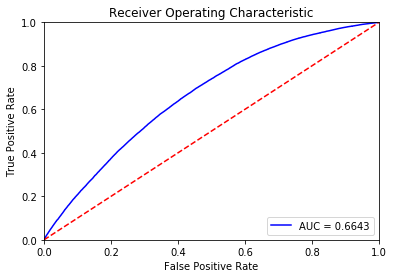

In [98]:
#ROC AUC Curve plotting
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [102]:
confusion_matrix(y_test,model.predict(X_test))

array([[107570,      0],
       [ 35587,      0]])

In [104]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86    107570
           1       0.00      0.00      0.00     35587

    accuracy                           0.75    143157
   macro avg       0.38      0.50      0.43    143157
weighted avg       0.56      0.75      0.64    143157



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
